# IPL Win Probability Predictor
### At a given amount of time, which team has what probabilty of winning the game, ye calculate karna hai!
Suppose, RCB vs MI ka match chal rha h so we will have to keep in mind shit tons of things like, kaunsi team abhi batting kar rhi h, kitne ka target h, and where is the match being played and all of that!<br>

just keeing in mind the dlc of any ml project
1. Frame the Problem -> predict the win probability of a match after second innings, given the stadium, target, crr, rrr, batsman, and ofc teams
2. Gathering Data -> kaggle se utha liya h ass it is(complete data of all the matches played in ipl till 2019)
3. Data Preprocessing -> rows are all sorted, data is already clean! no null values, no empty values, all good!
4. Exploratory Data Analysis -> 
5. Feature Engineering(column selection) -> we just needa identify the columns jo relevant h! which in our case are
6. Model Training (selecting a model, test_train_split and training the model)
7. Model Deployment (heraku pr )
8. Testing
9. Backup, improve the data, loadbalancing and shit! Optimize

## jo model train hoga, vo kuch neeche waale df ki tarah dikhega
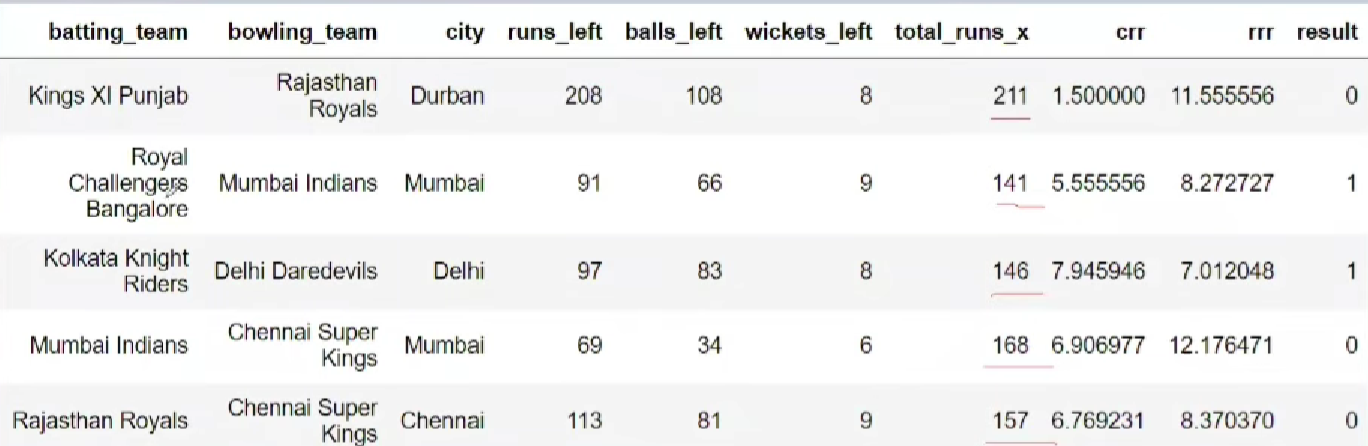
so we'll first make ammends by doing whatever we can to make our df like that!


In [284]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from matplotlib import pyplot as plt
import pickle
print("All libraries successfully imported")

In [285]:
#importing data
match_df=pd.read_csv("matches.csv")
delivery=pd.read_csv("deliveries.csv")
print()

In [286]:
# we need the runs scored in each inning, so that we can find the ki target kitna banana h, so that we can predict k bhai kaise banega itna!
#but in our data we have the the runs scored ballwise, in this case, we'd need to do some Feature Engineering
total_score = delivery.groupby(['match_id','inning']).sum()['total_runs'].reset_index() #reset_index just makes it a pandas ka df
total_score #is a multi-index series, through which we are getting a total_runs score per inning, every match

In [288]:
#but we only want the sum of runs for the first innings, as we are counting upon the TARGET, so cleaning that
total_score = total_score[total_score['inning'] == 1]
#total_score['total_runs']+=1 #incrementing all the values of total_runs by 1 as jitna first team banati h, second team ko us se 1 zyada banana hota h, target is 1 more than the sum run of team1
#print(total_score) #ye target hi print kr rha h, upar waali line comment kr di h, nhi to baar baar target 1 se bad jaa rha h :_)

#renaming the total_runs as target
total_score.rename(columns={'total_runs': 'target'}, inplace=True)
total_score

In [289]:
#Now that we have got the total runs scored per match as targets
#We'ld have to merge it in the initial matches DF, on the column, match_id
match_df = match_df.merge(total_score[['match_id','target']],left_on='id',right_on='match_id')
match_df

In [290]:
#DATA PRE-PROCESSING! in match_dfm
#thoda sa we'ld ahve to preprocess, as in the history of IPL there have been many teams that have played, who don't now! so we remove their names! :)

#looking for all the unique teams that play
match_df['team1'].unique()

#finalised name of teams added in a list, to go in the df
teams = [
    'Sunrisers Hyderabad',
    'Mumbai Indians',
    'Royal Challengers Bangalore',
    'Kolkata Knight Riders',
    'Kings XI Punjab',
    'Chennai Super Kings',
    'Rajasthan Royals',
    'Delhi Capitals'
]

#replacing team name from Delhi Daredevils to Delhi Capitals
match_df['team1'] = match_df['team1'].str.replace('Delhi Daredevils','Delhi Capitals')
match_df['team2'] = match_df['team2'].str.replace('Delhi Daredevils','Delhi Capitals')

#Replacing team name from Deccan Chargers to Sunrisers Hyderabad
match_df['team1'] = match_df['team1'].str.replace('Deccan Chargers','Sunrisers Hyderabad')
match_df['team2'] = match_df['team2'].str.replace('Deccan Chargers','Sunrisers Hyderabad')

#team1 and team2 k columns me sirf unhi teams ka naam rakho jo teams list me hai!
match_df = match_df[match_df['team1'].isin(teams)]
match_df = match_df[match_df['team2'].isin(teams)]

#also we want our model only to predict the values for non_dl matches! so we remove those rows where dl_applied = 1
match_df=match_df[match_df['dl_applied']==0]
match_df

In [291]:
#we just need these 4 column names in our final and adament datset! :O
match_df = match_df[['match_id','city','winner','target']]
match_df


In [292]:
#DATA PRE-PROCESSING in delivery_df
delivery_df = match_df.merge(delivery,on='match_id')
delivery_df

In [305]:
#sirf second innings ka data chahiye na! so why to worry for the first inning, hatao saale ko?!
delivery_df = delivery_df[delivery_df['inning'] == 2]
print(delivery_df)

In [297]:
#finding current runs, ki 1 particular ball pr kitne runs banaye h kisi team ne!
curr_score = delivery_df.groupby('match_id')
curr_score = curr_score['total_runs'].cumsum()
curr_df={ 'current_score':curr_score}
curr_df=pd.DataFrame(curr_df)
delivery_df['current_score']=curr_df['current_score']

In [309]:
delivery_df

In [321]:
#ab hume nikalna h runs left -> target - current_score
delivery_df['runs_left'] = delivery_df['target'] - delivery_df['current_score']

In [322]:
delivery_df

In [315]:
delivery_df['balls_left'] = 126 - (delivery_df['over']*6 + delivery_df['ball'])

In [316]:
delivery_df

In [326]:
#Wickets left nikalna padega!
delivery_df['player_dismissed'] = delivery_df['player_dismissed'].fillna("0") #player_dismessed ki nan values ko 0 kar do
delivery_df['player_dismissed'] = delivery_df['player_dismissed'].apply(lambda x:x if x == "0" else "1") #player_dismissed ki non nan values ko 1 kar do
delivery_df['player_dismissed'] = delivery_df['player_dismissed'].astype('int') #poore column ka type integer kr do

In [328]:
#1 column banana h cumsum karke, and usko append karna h delivery_df me
wickets = delivery_df.groupby('match_id')
wickets = wickets['player_dismissed'].cumsum()
delivery_df['wickets']=10-wickets

In [335]:
delivery_df.head(40)

In [339]:
#Calculating the crr => current_score/overs_happened
delivery_df['crr'] = (delivery_df['current_score']*6)/(120 - delivery_df['balls_left'])

#Calculating the rrr => runs_left/overs_left
delivery_df['rrr'] = (delivery_df['runs_left']*6)/delivery_df['balls_left']

In [340]:
delivery_df

In [341]:
#lastt column we have to work up is to bring the result in a binary, 0 or 1
#intution is if the winner == batting_team, then the result is 1 else 0. Remember we are only talking about the second innings, and are calculating the win probability at any given instance of time, after the target is set!
def result(row):
    return 1 if row['batting_team'] == row['winner'] else 0

In [343]:
delivery_df['result'] = delivery_df.apply(result,axis=1)

In [346]:
delivery_df.head(1)

In [349]:
#go to the first cell, and see that we were only looking for a select few columns on which our model will work, hooray we have got all of em!!!
final_df = delivery_df[['batting_team','bowling_team','city','runs_left','balls_left','wickets','target','crr','rrr','result']]
final_df

In [351]:
#shuffle the data, else, the model so trained will be baised!
final_df = final_df.sample(final_df.shape[0])
final_df

## test_train_split

In [353]:
final_df.dropna(inplace=True)
final_df = final_df[final_df['balls_left'] != 0]

In [355]:
X = final_df.iloc[:,:-1]
y = final_df.iloc[:,-1]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=1)

In [356]:
X_train

### Encoding (one-hot) 

In [376]:
#since our first three columns are strings, and a model can't work with that shit, so
#we'ld have to fuckin ONE-HOT encode them to nums
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

trf = ColumnTransformer([
    ('trf',OneHotEncoder(sparse=False,drop='first'),['batting_team','bowling_team','city'])
]
,remainder='passthrough')

### Model Selection & Training


In [358]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

### Pipeline banayenge
What is an ML pipeline? One definition of an ML pipeline is a means of automating the machine learning workflow by enabling data to be transformed and correlated into a model that can then be analyzed to achieve outputs. This type of ML pipeline makes the process of inputting data into the ML model fully automated.

In [399]:
pipe = Pipeline(steps=[
    ('step1',trf),
    ('step2',LogisticRegression(solver='liblinear'))#but if we want to show probabilities of winning, ie, who's likely to win, its better to use, Logistic Regression
    #('step2',RandomForestClassifier())#if we create an object of RandomForest, then the game is over, finish... tata tada.. 99.8% accurate model train ho rha h...
])  #in case we want to be absuletly sure of whose gonna win, we opt for Random forest in such cases

In [400]:
pipe.fit(X_train,y_train)

In [401]:
y_pred = pipe.predict(X_test)

In [402]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

In [403]:
pipe.predict_proba(X_test)[10]

In [395]:
def match_summary(row):
    print("Batting Team-" + row['batting_team'] + " | Bowling Team-" + row['bowling_team'] + " | Target- " + str(row['total_runs_x']))

In [404]:
def match_progression(x_df,match_id,pipe):
    match = x_df[x_df['match_id'] == match_id]
    match = match[(match['ball'] == 6)]
    temp_df = match[['batting_team','bowling_team','city','runs_left','balls_left','wickets','target','crr','rrr']].dropna()
    temp_df = temp_df[temp_df['balls_left'] != 0]
    result = pipe.predict_proba(temp_df)
    temp_df['lose'] = np.round(result.T[0]*100,1)
    temp_df['win'] = np.round(result.T[1]*100,1)
    temp_df['end_of_over'] = range(1,temp_df.shape[0]+1)
    
    target = temp_df['target'].values[0]
    runs = list(temp_df['runs_left'].values)
    new_runs = runs[:]
    runs.insert(0,target)
    temp_df['runs_after_over'] = np.array(runs)[:-1] - np.array(new_runs)
    wickets = list(temp_df['wickets'].values)
    new_wickets = wickets[:]
    new_wickets.insert(0,10)
    wickets.append(0)
    w = np.array(wickets)
    nw = np.array(new_wickets)
    temp_df['wickets_in_over'] = (nw - w)[0:temp_df.shape[0]]
    
    print("Target-",target)
    temp_df = temp_df[['end_of_over','runs_after_over','wickets_in_over','lose','win']]
    return temp_df,target

#if you give this functiton the entire detail of the match, match_id and if u give it your model, then this function will give you the win probability
#of the chasing team after the end of every over!


In [410]:
temp_df,target = match_progression(delivery_df,74,pipe)
temp_df

In [411]:
import matplotlib.pyplot as plt
plt.figure(figsize=(18,8))
plt.plot(temp_df['end_of_over'],temp_df['wickets_in_over'],color='yellow',linewidth=3)
plt.plot(temp_df['end_of_over'],temp_df['win'],color='#00a65a',linewidth=4)
plt.plot(temp_df['end_of_over'],temp_df['lose'],color='red',linewidth=4)
plt.bar(temp_df['end_of_over'],temp_df['runs_after_over'])
plt.title('Target-' + str(target))

In [373]:
teams

In [374]:
delivery_df['city'].unique()

In [375]:
import pickle
pickle.dump(pipe,open('pipe.pkl','wb'))